In [2]:
# # ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# # Verify you're in the right place
# !pwd
# !ls -la

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

2025-06-09 21:53:06.256342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 21:53:06.838071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749480787.035373   43884 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749480787.072244   43884 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749480787.433416   43884 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# GPU Configuration
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv("03 Result Data Cleaning Part 3.csv")
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.set_index('Tanggal')
df = df[['Katulampa (air)', 'Katulampa (cuaca)', 'Depok (air)', 'Depok (cuaca)', 'Manggarai (air)', 'Manggarai (cuaca)']]
df.head()

,Katulampa (air),Katulampa (cuaca),Depok (air),Depok (cuaca),Manggarai (air),Manggarai (cuaca)
Tanggal,,,,,,
2021-10-16 00:00:00,10.0,Mendung,80.0,Terang,555.0,Terang
2021-10-16 01:00:00,10.0,Mendung Tipis,95.0,Terang,555.0,Terang
2021-10-16 02:00:00,10.0,Mendung Tipis,95.0,Terang,555.0,Terang
2021-10-16 03:00:00,10.0,Mendung Tipis,90.0,Terang,555.0,Terang
2021-10-16 04:00:00,10.0,Mendung Tipis,90.0,Terang,560.0,Terang


# Data WITH weather

In [26]:
# Create new dataframe for lagged features
lagged_data = pd.DataFrame(index=df.index)

# Target variable (current Manggarai)
lagged_data['Manggarai Air'] = df['Manggarai (air)']

# Weather of the target variable
lagged_data['Manggarai Cuaca'] = df['Manggarai (cuaca)']

# Cross-correlation lags for Depok (8 hours back)
lagged_data['Depok Air Lag 8 '] = df['Depok (air)'].shift(8)
lagged_data['Depok Cuaca Lag 8'] = df['Depok (cuaca)'].shift(8)

# Cross-correlation lags for Katulampa (12 hours back)
lagged_data['Katulampa Air Lag 12'] = df['Katulampa (air)'].shift(12)
lagged_data['Katulampa Cuaca Lag 12'] = df['Katulampa (cuaca)'].shift(12)

# Check for missing values (due to shifting)
print(lagged_data.head())
print(f'\nLagged Data Shape: {lagged_data.shape}\n')
print('Missing values due to shifting:')
print(lagged_data.isnull().sum())

# Remove rows with missing values (caused by lagging)
lagged_data = lagged_data.dropna()
print(f"\nAfter removing missing values: {lagged_data.shape}")

# Identify all columns that have "cuaca" in their name and create new df for X categorical
X_cat = pd.DataFrame(index=lagged_data.index)
cuaca_columns = [col for col in lagged_data.columns if 'Cuaca' in col]

# One-hot encoding the cuaca columns
for col in cuaca_columns:
    cuaca_one_hot = pd.get_dummies(lagged_data[col], prefix=col)
    X_cat = pd.concat([X_cat, cuaca_one_hot], axis=1)

terang_columns = [col for col in X_cat.columns if 'Terang' in col]
for col in terang_columns:
    X_cat.drop(col, axis=1, inplace=True)

print(X_cat.head)

                     Manggarai Air Manggarai Cuaca  Depok Air Lag 8   \
Tanggal                                                                
2021-10-16 00:00:00          555.0          Terang               NaN   
2021-10-16 01:00:00          555.0          Terang               NaN   
2021-10-16 02:00:00          555.0          Terang               NaN   
2021-10-16 03:00:00          555.0          Terang               NaN   
2021-10-16 04:00:00          560.0          Terang               NaN   

                    Depok Cuaca Lag 8  Katulampa Air Lag 12  \
Tanggal                                                       
2021-10-16 00:00:00              None                   NaN   
2021-10-16 01:00:00              None                   NaN   
2021-10-16 02:00:00              None                   NaN   
2021-10-16 03:00:00              None                   NaN   
2021-10-16 04:00:00              None                   NaN   

                    Katulampa Cuaca Lag 12  
Tanggal 

In [27]:
# Convert to np array for X categorical
X_cat = X_cat.values

# Create new np array for X numerical
air_columns = [col for col in lagged_data.columns if 'Air' in col]
X_num = lagged_data[air_columns].values

# Split data
split_index = int(len(lagged_data) * 0.95)

X_num_train = X_num[:split_index]
X_num_test = X_num[split_index:]
X_cat_train = X_cat[:split_index]
X_cat_test = X_cat[split_index:]

# Scale only continuous features
scaler_X_num = MinMaxScaler()
X_num_train_scaled = scaler_X_num.fit_transform(X_num_train)
X_num_test_scaled = scaler_X_num.transform(X_num_test)

# Combine scaled continuous with unscaled binary features
X_train = np.concatenate([X_num_train_scaled, X_cat_train], axis=1)
X_test = np.concatenate([X_num_test_scaled, X_cat_test], axis=1)

# Scale target variable
y = lagged_data['Manggarai Air'].values
y_train = y[:split_index]
y_test = y[split_index:]

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

print(f"\n{'='*60}\nData Train and Test Distribution:\n{'='*60}")
print(f'Jumlah data: {len(lagged_data)}')
print(f'Jumlah data X train: {len(X_train)}')
print(f'Jumlah data X test: {len(X_test)}')
print(f'Jumlah data y train: {len(y_train)}')
print(f'Jumlah data y test: {len(y_test)}')


Data Train and Test Distribution:
Jumlah data: 31212
Jumlah data X train: 29651
Jumlah data X test: 1561
Jumlah data y train: 29651
Jumlah data y test: 1561


In [28]:
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    
    for i in range(sequence_length, len(X)):
        # Take sequence_length previous time steps as features
        X_seq.append(X[i-sequence_length:i])
        # Current time step as target
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

In [30]:
# Create sequences
SEQUENCE_LENGTH = 24

X_seq, y_seq = create_sequences(X_train, y_train_scaled, SEQUENCE_LENGTH)
print(f"Sequence features shape: {X_seq.shape}")
print(f"Sequence target shape: {y_seq.shape}")

Sequence features shape: (29627, 24, 15)
Sequence target shape: (29627,)


In [31]:
# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_seq.shape[2])),
    Dropout(0.2),
    
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    Dense(1)
])

I0000 00:00:1749486892.207704   43884 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [32]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [33]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,097 (531.63 KB)

 Trainable params: 136,097 (531.63 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [35]:
# Train the model
history = model.fit(
    X_seq, y_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1749486915.094911   62700 cuda_dnn.cc:529] Loaded cuDNN version 90300


741/741 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - loss: 0.0398 - mae: 0.1222 - val_loss: 0.0024 - val_mae: 0.0327 - learning_rate: 0.0010
Epoch 2/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0044 - mae: 0.0510 - val_loss: 0.0071 - val_mae: 0.0787 - learning_rate: 0.0010
Epoch 3/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0026 - mae: 0.0372 - val_loss: 0.0057 - val_mae: 0.0693 - learning_rate: 0.0010
Epoch 4/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 0.0054 - val_mae: 0.0682 - learning_rate: 0.0010
Epoch 5/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0048 - val_mae: 0.0641 - learning_rate: 0.0010
Epoch 6/100
740/741 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.7559e-04 - mae: 0.0198
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
741/741 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 9.7539e-04 - mae: 0.0198 - val_loss: 0.0033 - val_mae: 0.0514 - learning_

In [36]:
model.save("07b_best_model.keras")

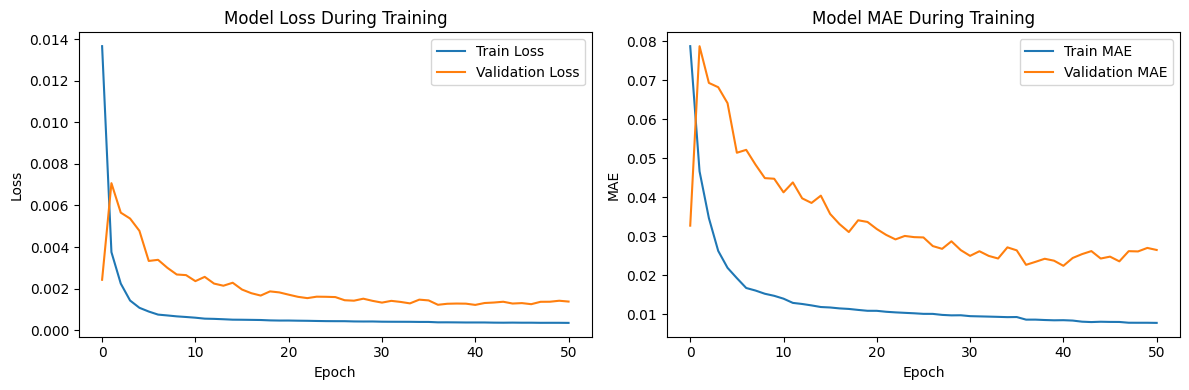

In [37]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Identify numeric columns excluding binary columns
# Binary columns typically have values 0 or 1
numeric_columns = np.isreal(X_test).all(axis=0)  # Detect all numeric columns
binary_columns = np.all((X_test == 0) | (X_test == 1), axis=0)  # Identify binary columns

# Exclude binary columns from numeric columns for scaling
columns_to_scale = numeric_columns & ~binary_columns  # True for numeric but not binary columns

# Scale only the numeric columns excluding binary ones
X_test_scaled = X_test.copy()
X_test_scaled[:, columns_to_scale] = scaler_X_num.transform(X_test[:, columns_to_scale])

# Create sequences for the scaled data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\nTest sequence shape: {X_test_seq.shape}")
print(f"Test target shape: {y_test_seq.shape}")

# Make predictions on test set
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
# Avoid division by zero
mask = y_test_seq != 0
mape = np.mean(np.abs((y_test_seq[mask] - y_pred.flatten()[mask]) / y_test_seq[mask])) * 100

print(f"\n{'='*60}\nModel Performance on Test Set:\n{'='*60}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Test sequence shape: (1537, 24, 15)
Test target shape: (1537,)
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

Model Performance on Test Set:
RMSE: 41.7495
MAE: 32.8668
R² Score: -1.2118
MAPE: 6.15%


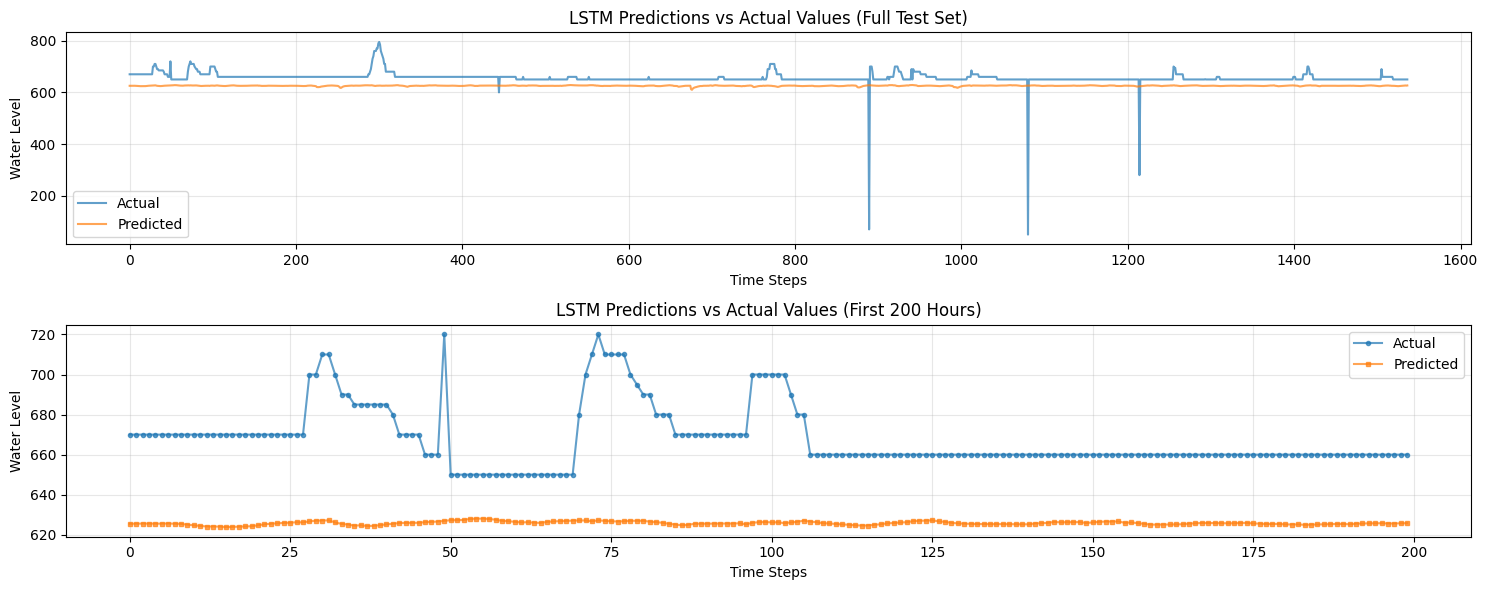

In [41]:
# Visualize predictions vs actual
plt.figure(figsize=(15, 6))

# Plot 1: Full test set predictions
plt.subplot(2, 1, 1)
plt.plot(y_test_seq, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('LSTM Predictions vs Actual Values (Full Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed view (first 200 hours)
plt.subplot(2, 1, 2)
zoom_length = min(200, len(y_test_seq))
plt.plot(y_test_seq[:zoom_length], label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred[:zoom_length], label='Predicted', marker='s', markersize=3, alpha=0.7)
plt.title('LSTM Predictions vs Actual Values (First 200 Hours)')
plt.xlabel('Time Steps')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

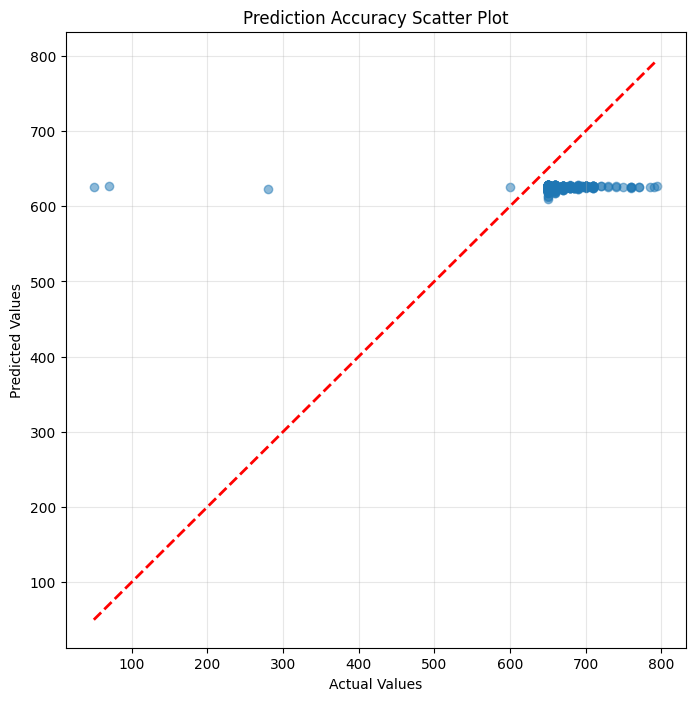

In [42]:
# Create scatter plot for prediction accuracy
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, y_pred, alpha=0.5)
plt.plot([y_test_seq.min(), y_test_seq.max()], 
         [y_test_seq.min(), y_test_seq.max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Accuracy Scatter Plot')
plt.grid(True, alpha=0.3)
plt.show()

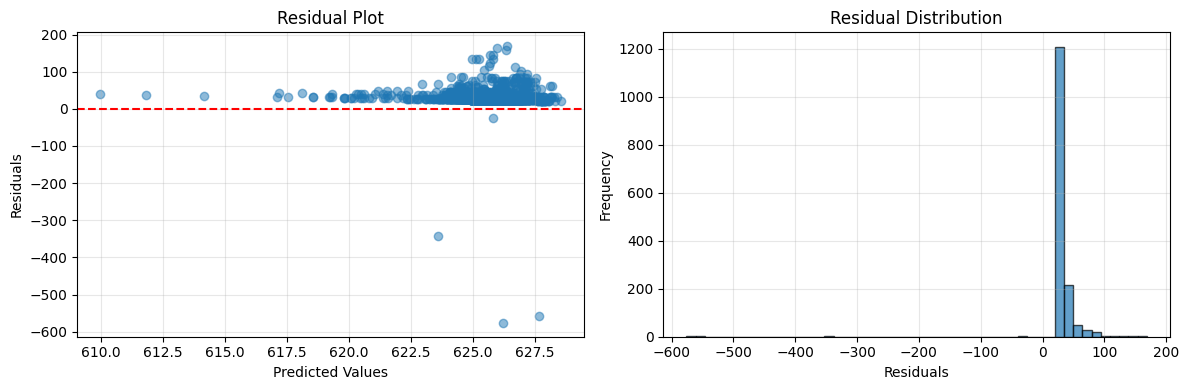


Sample Predictions (First 10):
Actual: 670.00, Predicted: 625.46, Error: 44.54
Actual: 670.00, Predicted: 625.53, Error: 44.47
Actual: 670.00, Predicted: 625.56, Error: 44.44
Actual: 670.00, Predicted: 625.52, Error: 44.48
Actual: 670.00, Predicted: 625.53, Error: 44.47
Actual: 670.00, Predicted: 625.53, Error: 44.47
Actual: 670.00, Predicted: 625.59, Error: 44.41
Actual: 670.00, Predicted: 625.53, Error: 44.47
Actual: 670.00, Predicted: 625.42, Error: 44.58
Actual: 670.00, Predicted: 625.01, Error: 44.99


In [43]:
# Residual analysis
residuals = y_test_seq - y_pred.flatten()

plt.figure(figsize=(12, 4))

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Residual histogram
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print sample predictions
print(f"\n{'='*60}\nSample Predictions (First 10):\n{'='*60}")
for i in range(min(10, len(y_test_seq))):
    print(f"Actual: {y_test_seq[i]:.2f}, Predicted: {y_pred[i][0]:.2f}, "
          f"Error: {abs(y_test_seq[i] - y_pred[i][0]):.2f}")